# Model Prototyping

After we has resampled the data, we can start prototyping our model. We will use CatBoost, a gradient boosting library that is particularly effective for tabular data.


In [1]:
import pandas as pd

from stroke_prediction.config import PROCESSED_DATA_DIR

train_data = pd.read_parquet(PROCESSED_DATA_DIR / "train-stroke-data-resampled.parquet")
val_data = pd.read_parquet(PROCESSED_DATA_DIR / "val-stroke-data.parquet")
test_data = pd.read_parquet(PROCESSED_DATA_DIR / "test-stroke-data.parquet")

In [2]:
from catboost import Pool

X_train = train_data.drop(columns=["stroke"])
y_train = train_data["stroke"]

X_val = val_data.drop(columns=["stroke"])
y_val = val_data["stroke"]

X_test = test_data.drop(columns=["stroke"])
y_test = test_data["stroke"]

train_pool = Pool(
    data=X_train,
    label=y_train,
)
val_pool = Pool(data=X_val, label=y_val)
test_pool = Pool(data=X_test, label=y_test)

We will log the model parameters and the model itself using MLFlows, which allows us to track our experiments and compare different runs.


In [3]:
import mlflow

from stroke_prediction.util import get_or_create_experiment

mlflow.set_tracking_uri("https://mlflow.spikehub.win/")
experiment_id = get_or_create_experiment("Stroke Prediction Evaluation")

After loading the data, we will tuning the model using optuna with TPE Sampler. The objective function will be defined to maximize the F1 score, which is a good metric for imbalanced datasets.


## Try Different Models

In [37]:
import optuna
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier


def objective(trail: optuna.Trial) -> float:
    params = {
        "criterion": trail.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trail.suggest_int("max_depth", 1, 10),
        "min_samples_split": trail.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trail.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
    }

    model = DecisionTreeClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    return f1

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=300)

In [38]:
tree_best_params = study.best_params
tree_best_params

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_split': 5,
 'min_samples_leaf': 3}

In [39]:
dt_cls = DecisionTreeClassifier(**tree_best_params)
dt_cls.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3,
                       min_samples_split=5)

13

In [42]:
import onnx

onnx.save_model(onnx_model, "decision_tree_model.onnx")

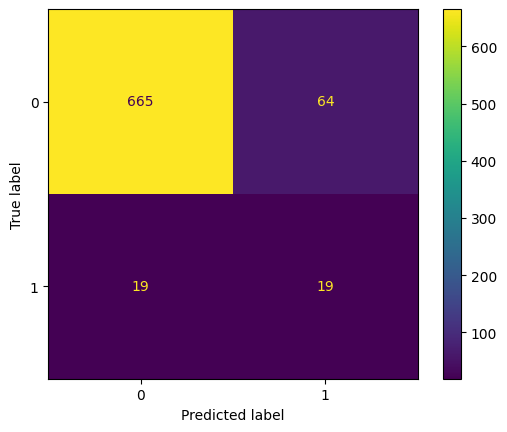

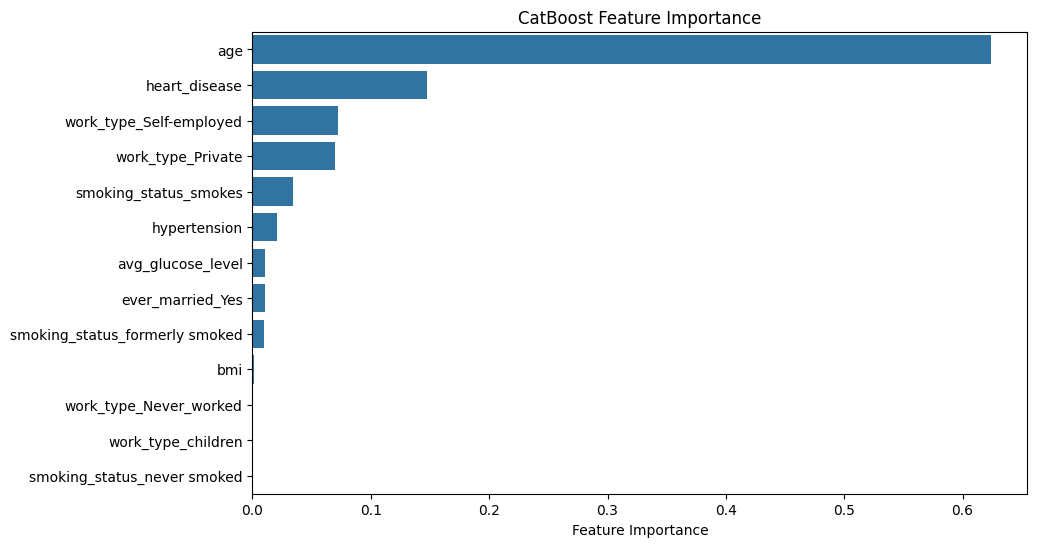

2025/05/27 22:44:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Successfully registered model 'DecisionTreeClassifier'.
2025/05/27 22:44:31 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier, version 1


🏃 View run hilarious-moth-905 at: https://mlflow.spikehub.win/#/experiments/3/runs/6f80e9c84f35488d83b6ad9a94295778
🧪 View experiment at: https://mlflow.spikehub.win/#/experiments/3


Created version '1' of model 'DecisionTreeClassifier'.


<Figure size 640x480 with 0 Axes>

In [7]:
import mlflow.sklearn
from sklearn.metrics import ConfusionMatrixDisplay

from stroke_prediction.plot import plot_feature_importance

with mlflow.start_run(experiment_id=experiment_id):
    dt_cls = DecisionTreeClassifier(**tree_best_params)
    dt_cls.fit(X_train, y_train)

    y_test_pred = dt_cls.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    feature_importance = pd.Series(
        dt_cls.feature_importances_, index=X_train.columns, name="importance")

    confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    feature_importance = plot_feature_importance(feature_importance)

    mlflow.log_figure(confusion_matrix.figure_, "confusion_matrix.png")
    mlflow.log_figure(feature_importance, "feature_importance.png")

    mlflow.log_params(tree_best_params)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow.set_tags(
        tags={
            "project": "stroke_prediction",
            "optimizer_engine": "optuna",
            "model_family": "DecisionTree",
            "model_type": "classifier",
        }
    )

    signature = mlflow.models.infer_signature(X_train.iloc[0:5], dt_cls.predict(X_train.iloc[0:5]))

    mlflow.sklearn.log_model(
        dt_cls,
        artifact_path="sklearn_model",
        registered_model_name="DecisionTreeClassifier",
        signature=signature,
        input_example=X_train.iloc[0:5],
    )

## Try Random Forest

In [34]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

optuna.logging.set_verbosity(optuna.logging.WARN)


def objective(trail: optuna.Trial) -> float:
    params = {
        "n_estimators": trail.suggest_int("n_estimators", 50, 200),
        "criterion": trail.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trail.suggest_int("max_depth", 1, 10),
        "min_samples_split": trail.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trail.suggest_int("min_samples_leaf", 1, 10),
        "random_state": 42,
    }

    model = RandomForestClassifier(**params)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    return f1

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=300)

In [35]:
rf_best_params = study.best_params
rf_best_params

{'n_estimators': 197,
 'criterion': 'gini',
 'max_depth': 4,
 'min_samples_split': 6,
 'min_samples_leaf': 1}

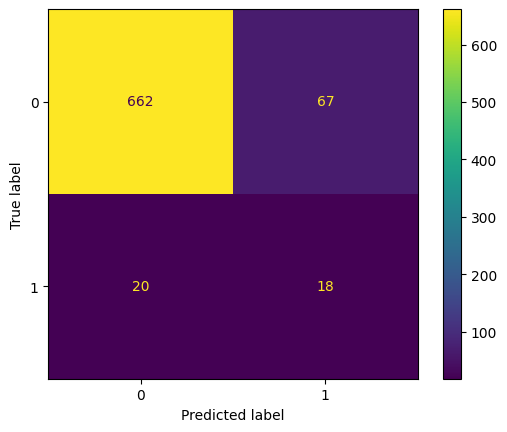

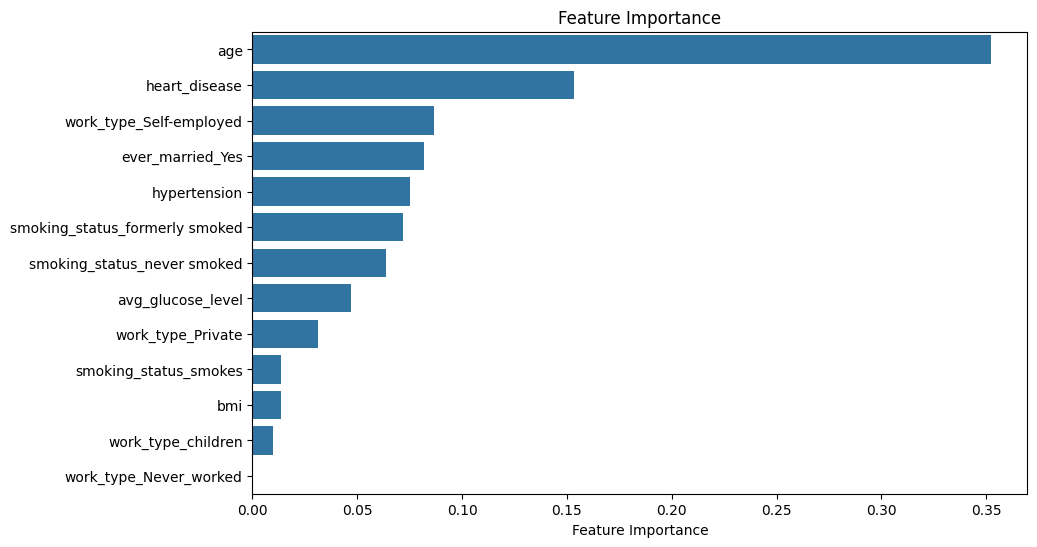

2025/05/28 00:23:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Successfully registered model 'RandomForestClassifier'.
2025/05/28 00:23:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestClassifier, version 1
Created version '1' of model 'RandomForestClassifier'.


🏃 View run wise-koi-57 at: https://mlflow.spikehub.win/#/experiments/3/runs/e77a471f2b6b48228d7c0f91f70cb95e
🧪 View experiment at: https://mlflow.spikehub.win/#/experiments/3


<Figure size 640x480 with 0 Axes>

In [36]:
with mlflow.start_run(experiment_id=experiment_id):
    cls = RandomForestClassifier(**rf_best_params)
    cls.fit(X_train, y_train)

    y_test_pred = cls.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    feature_importance = pd.Series(
        cls.feature_importances_, index=X_train.columns, name="importance")

    confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    feature_importance = plot_feature_importance(feature_importance)

    mlflow.log_figure(confusion_matrix.figure_, "confusion_matrix.png")
    mlflow.log_figure(feature_importance, "feature_importance.png")

    mlflow.log_params(cls.get_params())
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow.set_tags(
        tags={
            "project": "stroke_prediction",
            "optimizer_engine": "optuna",
            "model_family": "RandomForest",
            "model_type": "classifier",
        }
    )

    signature = mlflow.models.infer_signature(X_train.iloc[0:5], cls.predict(X_train.iloc[0:5]))

    mlflow.sklearn.log_model(
        cls,
        artifact_path="sklearn_model",
        registered_model_name="RandomForestClassifier",
        signature=signature,
        input_example=X_train.iloc[0:5],
    )

## Try Neural Networks

In [4]:
import optuna
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier


def objective(trail: optuna.Trial) -> float:
    params = {
        "hidden_layer_sizes": trail.suggest_int("hidden_layer_sizes", 50, 200),
        "activation": trail.suggest_categorical("activation", ["relu", "tanh"]),
        "solver": trail.suggest_categorical("solver", ["adam", "sgd"]),
        "alpha": trail.suggest_float("alpha", 1e-5, 1e-2, log=True),
        "learning_rate_init": trail.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        "beta_1": trail.suggest_float("beta_1", 0.5, 0.9),
        "beta_2": trail.suggest_float("beta_2", 0.9, 0.999),
        "epsilon": trail.suggest_float("epsilon", 1e-8, 1e-4, log=True),
        "max_iter": 300,
        "random_state": 42,
        "learning_rate": "adaptive"
    }

    model = MLPClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred)
    
    return f1

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2025-05-27 22:58:07,228] A new study created in memory with name: no-name-5d2c8bf8-f8d6-4dcc-9882-31d0db768e62
e:\Projects\stroke-prediction-api\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-05-27 22:58:10,697] Trial 0 finished with value: 0.26455026455026454 and parameters: {'hidden_layer_sizes': 106, 'activation': 'relu', 'solver': 'adam', 'alpha': 2.9375384576328295e-05, 'learning_rate_init': 0.00013066739238053285, 'beta_1': 0.846470458309974, 'beta_2': 0.9595103861625777, 'epsilon': 6.7965780907581515e-06}. Best is trial 0 with value: 0.26455026455026454.
[I 2025-05-27 22:58:12,254] Trial 1 finished with value: 0.2535211267605634 and parameters: {'hidden_layer_sizes': 53, 'activation': 'relu', 'solver': 'adam', 'alpha': 3.5498788321965036e-05, 'learning_rate_init': 0.0004059611610484307, 'beta_1': 0.709902

In [5]:
mlp_best_params = study.best_params
mlp_best_params

{'hidden_layer_sizes': 166,
 'activation': 'relu',
 'solver': 'adam',
 'alpha': 0.0015382308040279,
 'learning_rate_init': 0.0034877126245459306,
 'beta_1': 0.5296178606936361,
 'beta_2': 0.935488107125883,
 'epsilon': 2.907208890659844e-08}

2025/05/27 23:46:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Successfully registered model 'MLPClassifier'.
2025/05/27 23:46:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MLPClassifier, version 1
Created version '1' of model 'MLPClassifier'.


🏃 View run valuable-carp-779 at: https://mlflow.spikehub.win/#/experiments/3/runs/e262ca38f59444e0a03540514c0095fa
🧪 View experiment at: https://mlflow.spikehub.win/#/experiments/3


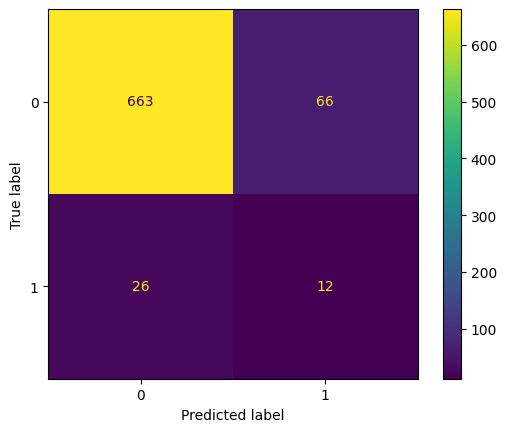

In [ ]:
with mlflow.start_run(experiment_id=experiment_id):
    cls = MLPClassifier(**mlp_best_params)
    cls.fit(X_train, y_train)

    y_test_pred = cls.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)

    mlflow.log_figure(confusion_matrix.figure_, "confusion_matrix.png")

    mlflow.log_params(cls.get_params())
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow.set_tags(
        tags={
            "project": "stroke_prediction",
            "optimizer_engine": "optuna",
            "model_family": "MLPClassifier",
            "model_type": "classifier",
        }
    )

    signature = mlflow.models.infer_signature(X_train.iloc[0:5], cls.predict(X_train.iloc[0:5]))

    mlflow.sklearn.log_model(
        cls,
        artifact_path="sklearn_model",
        registered_model_name="MLPClassifier",
        signature=signature,
        input_example=X_train.iloc[0:5],
    )

In [19]:
import shap

shap.initjs()

X_background = shap.sample(X_val, 100)

explainer = shap.KernelExplainer(cls.predict_proba, X_background)
shap_values = explainer.shap_values(X_test)

  0%|          | 0/767 [00:00<?, ?it/s]

In [27]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test[:1000])

## Try CatBoost


In [ ]:
# import optuna
# from catboost import CatBoostClassifier
# from optuna.integration import CatBoostPruningCallback
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# def objective(trial: optuna.Trial) -> float:
#     with mlflow.start_run(nested=True):
#         params = {
#             "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
#             "depth": trial.suggest_int("max_depth", 4, 10),
#             "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
#             "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#             "bootstrap_type": trial.suggest_categorical(
#                 "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#             ),
#             "eval_metric": "F1",
#             "auto_class_weights": "Balanced",
#             "random_seed": 42,
#         }

#         if params["bootstrap_type"] == "Bayesian":
#             params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#         elif params["bootstrap_type"] == "Bernoulli":
#             params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#         model = CatBoostClassifier(**params, verbose=0)

#         pruning_callback = CatBoostPruningCallback(trial, "F1")

#         model.fit(
#             train_pool,
#             eval_set=val_pool,
#             early_stopping_rounds=100,
#             callbacks=[pruning_callback],
#             verbose=0,
#         )

#         pruning_callback.check_pruned()

#         y_pred = model.predict(X_val)
#         f1 = f1_score(y_val, y_pred)
#         precision = precision_score(y_val, y_pred)
#         recall = recall_score(y_val, y_pred)
#         accuracy = accuracy_score(y_val, y_pred)

#         mlflow.log_params(params)
#         mlflow.log_metric("f1", f1)
#         mlflow.log_metric("precision", precision)
#         mlflow.log_metric("recall", recall)
#         mlflow.log_metric("accuracy", accuracy)

#     return f1

In [ ]:
# run_name = "First Tuning"

# with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):
#     study = optuna.create_study(
#         pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
#     )
#     study.optimize(objective, n_trials=300)

#     mlflow.log_params(study.best_params)
#     mlflow.log_metric("best_f1", study.best_value)

In [7]:
best_run = mlflow.get_run("a7f14a0dfabd4189a20df0f7d236615e")
mlflow_best_params = best_run.data.params

best_params = {
    "colsample_bylevel": float(mlflow_best_params["colsample_bylevel"]),
    "depth": int(mlflow_best_params["max_depth"]),
    "l2_leaf_reg": float(mlflow_best_params["l2_leaf_reg"]),
    "boosting_type": mlflow_best_params["boosting_type"],
    "bootstrap_type": mlflow_best_params["bootstrap_type"],
    "eval_metric": "F1",
    "auto_class_weights": "Balanced",
    "random_seed": 42,
}

In [9]:
best_params

{'colsample_bylevel': 0.09512938089563211,
 'depth': 8,
 'l2_leaf_reg': 8.115228714496485,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'eval_metric': 'F1',
 'auto_class_weights': 'Balanced',
 'random_seed': 42}

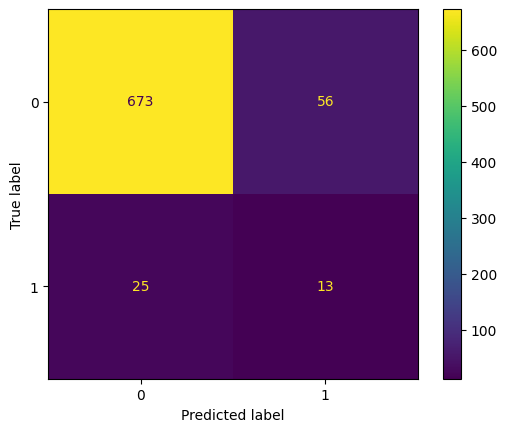

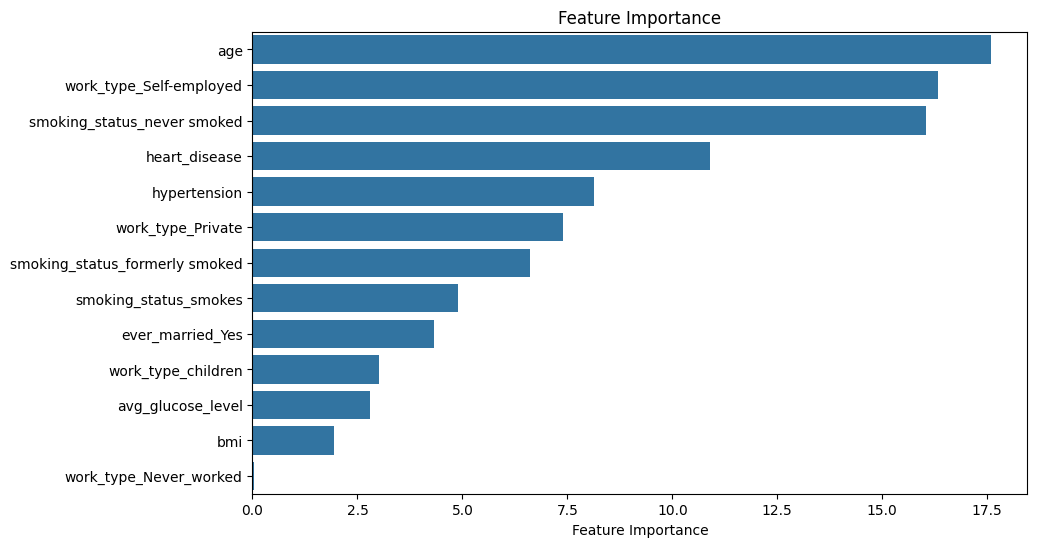

<Figure size 640x480 with 0 Axes>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay

from stroke_prediction.plot import plot_feature_importance

with mlflow.start_run(experiment_id=experiment_id):
    best_model = CatBoostClassifier(**best_params, verbose=0)

    best_model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=100,
        verbose=0,
    )

    y_test_pred = best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    feature_importance = pd.Series(
        best_model.feature_importances_, index=X_train.columns, name="importance")

    confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    feature_importance = plot_feature_importance(feature_importance)

    mlflow.log_figure(confusion_matrix.figure_, "confusion_matrix.png")
    mlflow.log_figure(feature_importance, "feature_importance.png")

    mlflow.log_params(best_params)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow.set_tags(
        tags={
            "project": "stroke_prediction",
            "optimizer_engine": "optuna",
            "model_family": "catboost",
            "model_type": "classifier",
        }
    )

    signature = mlflow.models.infer_signature(X_train.iloc[0:5], best_model.predict(X_train.iloc[0:5]))

    mlflow.catboost.log_model(
        best_model,
        artifact_path="catboost_model",
        registered_model_name="CatBoostStrokePredictionModel",
        signature=signature,
        input_example=X_train.iloc[0:5],
    )

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.force(shap_values[0, ...])
shap.force_plot(explainer.expected_value, shap_values.values[:1000, :], X_test.iloc[:1000, :])